In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#set ups
plt.rcParams['figure.figsize'] = (12, 10)

In [3]:
#data
PATH = '../data/wine.csv'

In [4]:
wine = pd.read_csv(PATH)

In [5]:
wine.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
wine.drop("index",inplace=True,axis=1)

In [7]:
wine[["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [8]:
wine["quality"].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [9]:
corr = wine.corr()

In [10]:
corr["quality"].sort_values(ascending = False)

quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64

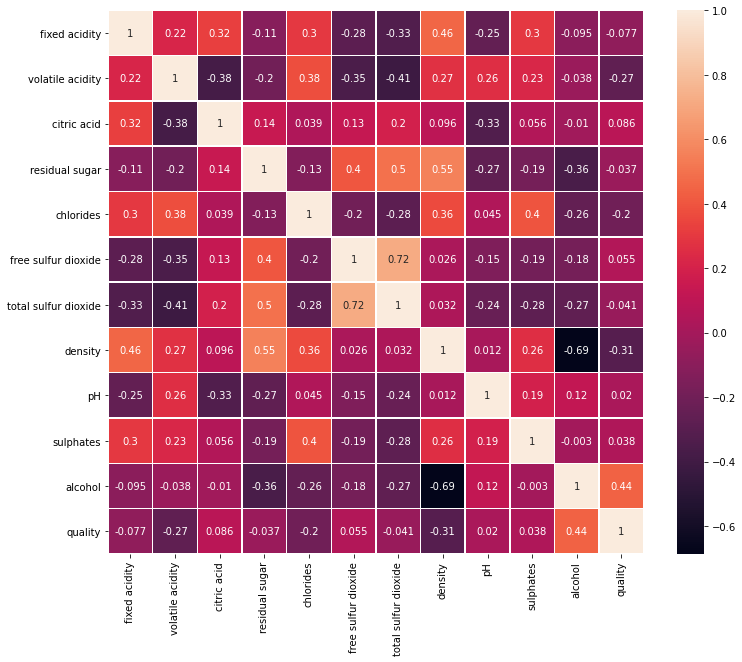

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr,annot=True, linewidths=.5, ax=ax)
plt.savefig("../img/corrheatmap.png",dpi=200)

In [12]:
np.bincount(wine['quality'])

array([   0,    0,    0,   30,  216, 2138, 2836, 1079,  193,    5],
      dtype=int64)

In [13]:
#wine.info()#data is clean, no NaN or wrong datatypes

# Model without modifications

In [14]:
wine_copy = wine.copy()

In [15]:
# Creating a test/train split
index_sep = 0.80
split_index = int(wine_copy.shape[0] * index_sep)
train = wine_copy[:split_index]
test = wine_copy[split_index:]
# Features selection
X_train = train.drop(['quality'], axis = 1).values
X_test = test.drop(['quality'], axis = 1).values
#Target = Quality
target = pd.get_dummies(wine_copy['quality']).values # One hot encode
y_train = target[:split_index]
y_test = target[split_index:]

### Model : 

In [16]:
output_shape = len(wine["quality"].unique()) # number of output node

In [17]:
output_shape 

7

In [18]:

input_shape = (X_train.shape[1],)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None,output_shape=output_shape,input_shape=input_shape):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(60,activation="sigmoid",input_shape=input_shape),
      keras.layers.Dense(30, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(output_shape, activation='softmax')
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=metrics)

  return model

## Baseline Model

In [19]:
EPOCHS = 30
BATCH_SIZE = 2500
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [20]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                720       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 217       
Total params: 2,767
Trainable params: 2,767
Non-trainable params: 0
_________________________________________________________________


In [21]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_split=0.2)

Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 2.1808 - tp: 227.0000 - fp: 412.3333 - tn: 21215.6667 - fn: 3377.6667 - accuracy: 0.8498 - precision: 0.3557 - recall: 0.0631 - auc: 0.5447 - val_loss: 2.1676 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6240.0000 - val_fn: 1040.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4909
Epoch 2/30
2/2 [==============================] - 0s 175ms/step - loss: 2.0337 - tp: 242.0000 - fp: 386.3333 - tn: 21241.6667 - fn: 3362.6667 - accuracy: 0.8514 - precision: 0.3850 - recall: 0.0673 - auc: 0.5861 - val_loss: 2.0012 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6240.0000 - val_fn: 1040.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5758
Epoch 3/30
2/2 [==============================] - 0s 172ms/step - loss: 1.9106 - tp: 233.6667 - fp: 352.0000 - tn: 21276.0000 - fn: 3371.0000 - accuracy: 0.8526 - precision: 0.4025 - recall

2/2 [==============================] - 0s 193ms/step - loss: 1.3838 - tp: 559.6667 - fp: 854.3333 - tn: 20773.6667 - fn: 3045.0000 - accuracy: 0.8456 - precision: 0.3968 - recall: 0.1557 - auc: 0.8328 - val_loss: 1.3885 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6240.0000 - val_fn: 1040.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8326
Epoch 22/30
2/2 [==============================] - 0s 188ms/step - loss: 1.3714 - tp: 532.3333 - fp: 794.3333 - tn: 20833.6667 - fn: 3072.3333 - accuracy: 0.8468 - precision: 0.4020 - recall: 0.1485 - auc: 0.8351 - val_loss: 1.3806 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6240.0000 - val_fn: 1040.0000 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8363
Epoch 23/30
2/2 [==============================] - 0s 244ms/step - loss: 1.3855 - tp: 485.6667 - fp: 790.3333 - tn: 20837.6667 - fn: 3119.0000 - accuracy: 0.8450 - precision: 0.3802 - recall: 0.13

In [22]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color="red", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="blue", linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()

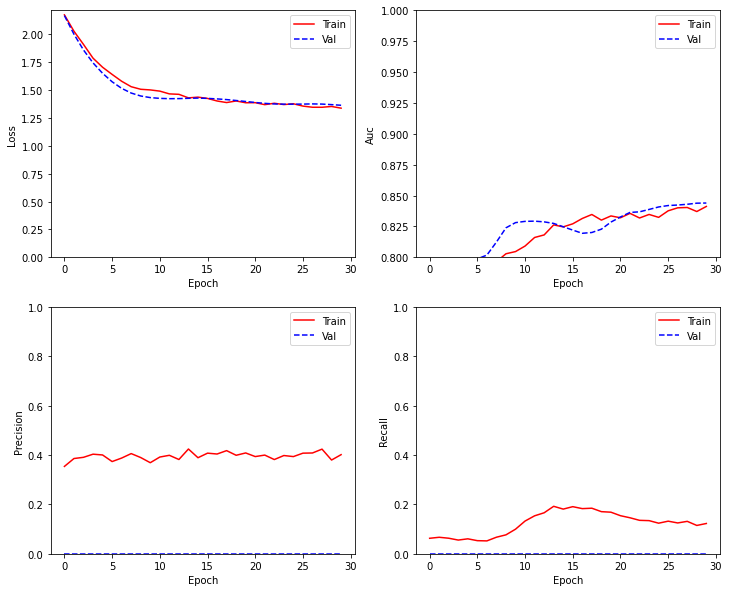

In [23]:
plot_metrics(baseline_history)

High acc but still high loss we need to resample our classes our deal with their weight

In [24]:
model.evaluate(X_test,y_test)

41/41 [==============================] - 0s 3ms/step - loss: 1.2179 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7800.0000 - fn: 1300.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8815


[1.2179025411605835,
 0.0,
 0.0,
 7800.0,
 1300.0,
 0.857142984867096,
 0.0,
 0.0,
 0.8814684152603149]

In [25]:
model.predict(X_test[:3])

array([[0.0206465 , 0.03852674, 0.34540388, 0.41552654, 0.14637005,
        0.02639594, 0.00713039],
       [0.01208551, 0.03997575, 0.41436762, 0.38293493, 0.12573898,
        0.01899052, 0.00590672],
       [0.02180868, 0.04253729, 0.3552949 , 0.39938566, 0.14450382,
        0.0280765 , 0.00839313]], dtype=float32)

In [26]:
y_test[:3]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

----------------------------------------------------------------

# Wine_modif

In [27]:
wine_modif = wine.copy()

### Total Sulfur Dioxide - [Why it Matters, Too!](https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too#:~:text=Simply%20put%2C%20Total%20Sulfur%20Dioxide,aldehydes%2C%20pigments%2C%20or%20sugars.)

In [28]:
#ratio TSO2 /FSO2
wine_modif["ratioSO2"] = wine_modif["free sulfur dioxide"] / wine_modif["total sulfur dioxide"]

In [29]:
wine_modif.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,ratioSO2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.323529
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.373134
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.277778


### Train test split on wine_modif

In [30]:
# Creating a test/train split
index_sep = 0.80
split_index = int(wine_modif.shape[0] * index_sep)
train_features = wine_modif[:split_index]
test_features = wine_modif[split_index:]
# Features selection
X_train = train_features.drop(['quality'], axis = 1).values
X_test = test_features.drop(['quality'], axis = 1).values
#Target = Quality
target = pd.get_dummies(wine_modif['quality']).values # One hot encode
train_target = target[:split_index]
test_target = target[split_index:]

### Normalize the data

In [31]:
mean = np.mean(train_features, axis=0)
train_features -= mean
test_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
test_features /= std

In [32]:
train_features.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,ratioSO2
0,0.000136,1.987462,-2.103896,-0.700044,0.469353,-1.045667,-1.308185,0.948097,1.706789,0.123036,-0.886439,-0.903025,0.250410
1,0.297489,3.018836,-2.103896,-0.549633,1.060226,-0.251390,-0.756489,0.605819,-0.196591,0.898637,-0.540416,-0.903025,0.633522
2,0.297489,2.331253,-1.842649,-0.614095,0.899079,-0.818730,-0.973824,0.674275,0.171805,0.704737,-0.540416,-0.903025,-0.102942
3,2.824987,-0.419078,1.553554,-0.700044,0.442496,-0.705262,-0.873515,1.016553,-0.442189,0.252303,-0.540416,0.221052,-0.060035
4,0.000136,1.987462,-2.103896,-0.700044,0.469353,-1.045667,-1.308185,0.948097,1.706789,0.123036,-0.886439,-0.903025,0.250410


### Model with features tweaked

In [33]:
input_shape = (train_features.shape[1],)

In [34]:
model = make_model(input_shape=input_shape)

In [41]:
tweaked_history = model.fit(
    train_features,
    train_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_split=0.2)

Epoch 1/30
2/2 [==============================] - 0s 165ms/step - loss: 1.2342 - tp: 912.0000 - fp: 691.0000 - tn: 24251.0000 - fn: 3245.0000 - accuracy: 0.8647 - precision: 0.5689 - recall: 0.2194 - auc: 0.8734 - val_loss: 1.2048 - val_tp: 45.0000 - val_fp: 141.0000 - val_tn: 6099.0000 - val_fn: 995.0000 - val_accuracy: 0.8440 - val_precision: 0.2419 - val_recall: 0.0433 - val_auc: 0.8839
Epoch 2/30
2/2 [==============================] - 0s 105ms/step - loss: 1.2150 - tp: 997.0000 - fp: 660.0000 - tn: 24282.0000 - fn: 3160.0000 - accuracy: 0.8687 - precision: 0.6017 - recall: 0.2398 - auc: 0.8770 - val_loss: 1.1972 - val_tp: 54.0000 - val_fp: 156.0000 - val_tn: 6084.0000 - val_fn: 986.0000 - val_accuracy: 0.8431 - val_precision: 0.2571 - val_recall: 0.0519 - val_auc: 0.8852
Epoch 3/30
2/2 [==============================] - 0s 125ms/step - loss: 1.2122 - tp: 1016.0000 - fp: 690.0000 - tn: 24252.0000 - fn: 3141.0000 - accuracy: 0.8683 - precision: 0.5955 - recall: 0.2444 - auc: 0.8782 -

Epoch 22/30
2/2 [==============================] - 0s 112ms/step - loss: 1.0814 - tp: 1481.0000 - fp: 779.0000 - tn: 24163.0000 - fn: 2676.0000 - accuracy: 0.8813 - precision: 0.6553 - recall: 0.3563 - auc: 0.9045 - val_loss: 1.0471 - val_tp: 250.0000 - val_fp: 241.0000 - val_tn: 5999.0000 - val_fn: 790.0000 - val_accuracy: 0.8584 - val_precision: 0.5092 - val_recall: 0.2404 - val_auc: 0.9117
Epoch 23/30
2/2 [==============================] - 0s 119ms/step - loss: 1.0719 - tp: 1551.0000 - fp: 770.0000 - tn: 24172.0000 - fn: 2606.0000 - accuracy: 0.8840 - precision: 0.6682 - recall: 0.3731 - auc: 0.9055 - val_loss: 1.0399 - val_tp: 262.0000 - val_fp: 234.0000 - val_tn: 6006.0000 - val_fn: 778.0000 - val_accuracy: 0.8610 - val_precision: 0.5282 - val_recall: 0.2519 - val_auc: 0.9131
Epoch 24/30
2/2 [==============================] - 0s 105ms/step - loss: 1.0682 - tp: 1517.0000 - fp: 796.0000 - tn: 24146.0000 - fn: 2640.0000 - accuracy: 0.8819 - precision: 0.6559 - recall: 0.3649 - auc: 0

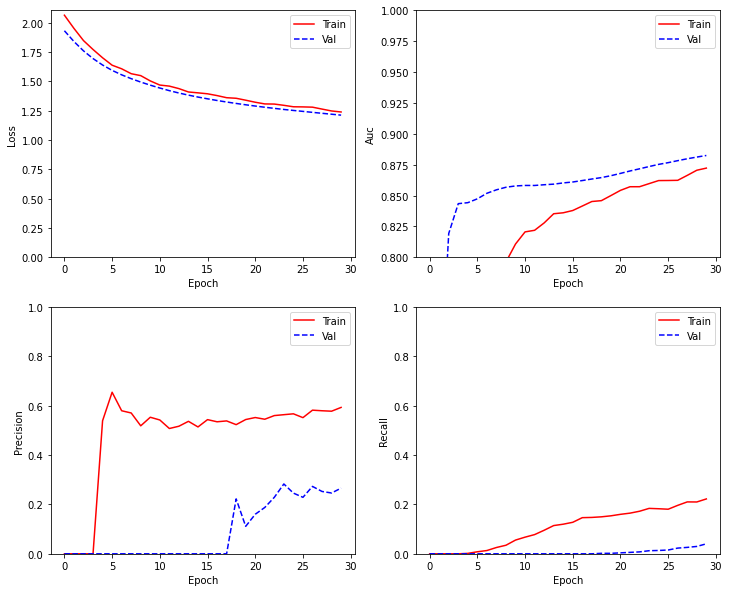

In [36]:
plot_metrics(tweaked_history)

In [42]:
len(test_features)

1300

In [43]:
model.evaluate(test_features,test_target)

41/41 [==============================] - 0s 2ms/step - loss: 0.8933 - tp: 560.0000 - fp: 192.0000 - tn: 7608.0000 - fn: 740.0000 - accuracy: 0.8976 - precision: 0.7447 - recall: 0.4308 - auc: 0.9455


[0.8932563662528992,
 560.0,
 192.0,
 7608.0,
 740.0,
 0.897582471370697,
 0.7446808218955994,
 0.4307692348957062,
 0.9455165266990662]

In [39]:
from sklearn.metrics import confusion_matrix

pred = model.predict(test_features)
confusion = confusion_matrix(test_target.argmax(axis=1), pred.argmax(axis=1))
print('Confusion Matrix\n')
confusion

Confusion Matrix



array([[  0,   0,   2,   0,   0,   0],
       [  0,   0,  31,   2,   0,   0],
       [  0,   0, 287,  77,   0,   0],
       [  0,   0,  61, 593,   0,   0],
       [  0,   0,   0, 216,   0,   0],
       [  0,   0,   0,  31,   0,   0]], dtype=int64)

In [40]:
stop

NameError: name 'stop' is not defined

In [ ]:
#wine["quality"].value_counts()

In [ ]:
#from sklearn.metrics import classification_report
#print('\nClassification Report\n')
#print(classification_report(test_target.argmax(axis=1),pred.argmax(axis=1)))

------------------------------------------------------------------------------------------------------

### Class weights

In [44]:
counts = np.bincount(wine_modif['quality'].values)

In [45]:
weights = wine_modif['quality'].value_counts()/len(wine_modif)

In [46]:
 x = weights.to_dict()

In [47]:
x

{6: 0.43650915807295676,
 5: 0.32907495767277206,
 7: 0.1660766507618901,
 4: 0.0332461135908881,
 8: 0.02970601816222872,
 3: 0.0046175157765122364,
 9: 0.0007695859627520394}

In [48]:
labels = wine_modif['quality'].values
y_w = labels[:split_index]

In [49]:
from sklearn.utils import class_weight
class_weights = dict(zip([0,1,2,3,4,5,6], class_weight.compute_class_weight(None, classes = np.unique(y_w), 
                y=y_w))) 

# Let's test with weight changes

In [50]:
weighted_model = make_model(input_shape=input_shape)

In [54]:
weighted_history = weighted_model.fit(
    train_features,
    train_target,
    batch_size=BATCH_SIZE,
    epochs=50,
    #callbacks=[early_stopping],
    validation_split=0.2,
    # The class weights go here
    class_weight=class_weights)

Epoch 1/50
2/2 [==============================] - 0s 220ms/step - loss: 1.0634 - tp: 1665.0000 - fp: 804.0000 - tn: 24138.0000 - fn: 2492.0000 - accuracy: 0.8867 - precision: 0.6744 - recall: 0.4005 - auc: 0.9059 - val_loss: 1.0680 - val_tp: 357.0000 - val_fp: 326.0000 - val_tn: 5914.0000 - val_fn: 683.0000 - val_accuracy: 0.8614 - val_precision: 0.5227 - val_recall: 0.3433 - val_auc: 0.8994
Epoch 2/50
2/2 [==============================] - 0s 122ms/step - loss: 1.0605 - tp: 1595.0000 - fp: 758.0000 - tn: 24184.0000 - fn: 2562.0000 - accuracy: 0.8859 - precision: 0.6779 - recall: 0.3837 - auc: 0.9067 - val_loss: 1.0588 - val_tp: 362.0000 - val_fp: 323.0000 - val_tn: 5917.0000 - val_fn: 678.0000 - val_accuracy: 0.8625 - val_precision: 0.5285 - val_recall: 0.3481 - val_auc: 0.9025
Epoch 3/50
2/2 [==============================] - 0s 133ms/step - loss: 1.0548 - tp: 1678.0000 - fp: 769.0000 - tn: 24173.0000 - fn: 2479.0000 - accuracy: 0.8884 - precision: 0.6857 - recall: 0.4037 - auc: 0.90

Epoch 22/50
2/2 [==============================] - 0s 124ms/step - loss: 0.9179 - tp: 2226.0000 - fp: 719.0000 - tn: 24223.0000 - fn: 1931.0000 - accuracy: 0.9089 - precision: 0.7559 - recall: 0.5355 - auc: 0.9310 - val_loss: 0.8867 - val_tp: 599.0000 - val_fp: 141.0000 - val_tn: 6099.0000 - val_fn: 441.0000 - val_accuracy: 0.9201 - val_precision: 0.8095 - val_recall: 0.5760 - val_auc: 0.9450
Epoch 23/50
2/2 [==============================] - 0s 152ms/step - loss: 0.9029 - tp: 2240.0000 - fp: 682.0000 - tn: 24260.0000 - fn: 1917.0000 - accuracy: 0.9107 - precision: 0.7666 - recall: 0.5389 - auc: 0.9335 - val_loss: 0.8785 - val_tp: 603.0000 - val_fp: 136.0000 - val_tn: 6104.0000 - val_fn: 437.0000 - val_accuracy: 0.9213 - val_precision: 0.8160 - val_recall: 0.5798 - val_auc: 0.9465
Epoch 24/50
2/2 [==============================] - 0s 127ms/step - loss: 0.8919 - tp: 2281.0000 - fp: 686.0000 - tn: 24256.0000 - fn: 1876.0000 - accuracy: 0.9120 - precision: 0.7688 - recall: 0.5487 - auc: 0

Epoch 43/50
2/2 [==============================] - 0s 105ms/step - loss: 0.7739 - tp: 2834.0000 - fp: 571.0000 - tn: 24371.0000 - fn: 1323.0000 - accuracy: 0.9349 - precision: 0.8323 - recall: 0.6817 - auc: 0.9510 - val_loss: 0.7278 - val_tp: 785.0000 - val_fp: 104.0000 - val_tn: 6136.0000 - val_fn: 255.0000 - val_accuracy: 0.9507 - val_precision: 0.8830 - val_recall: 0.7548 - val_auc: 0.9648
Epoch 44/50
2/2 [==============================] - 0s 121ms/step - loss: 0.7743 - tp: 2840.0000 - fp: 566.0000 - tn: 24376.0000 - fn: 1317.0000 - accuracy: 0.9353 - precision: 0.8338 - recall: 0.6832 - auc: 0.9518 - val_loss: 0.7208 - val_tp: 791.0000 - val_fp: 104.0000 - val_tn: 6136.0000 - val_fn: 249.0000 - val_accuracy: 0.9515 - val_precision: 0.8838 - val_recall: 0.7606 - val_auc: 0.9653
Epoch 45/50
2/2 [==============================] - 0s 109ms/step - loss: 0.7669 - tp: 2878.0000 - fp: 543.0000 - tn: 24399.0000 - fn: 1279.0000 - accuracy: 0.9374 - precision: 0.8413 - recall: 0.6923 - auc: 0

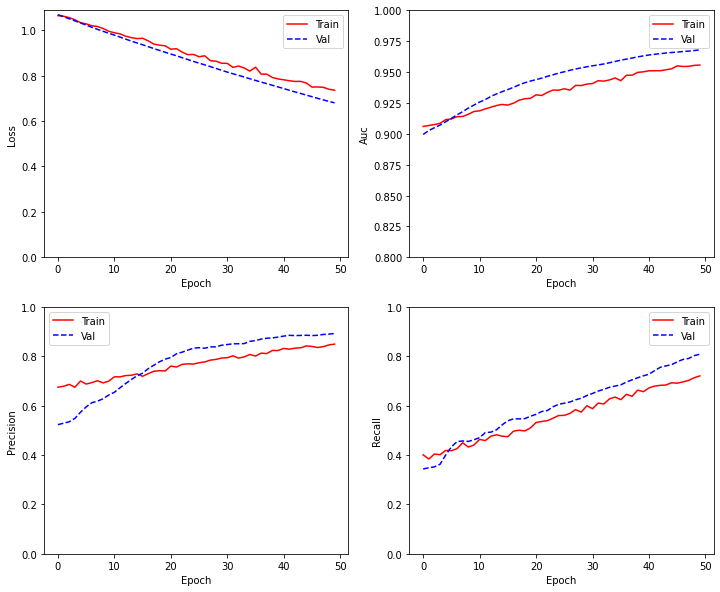

In [55]:
plot_metrics(weighted_history)

In [56]:
weighted_model.evaluate(test_features,test_target)

41/41 [==============================] - 0s 1ms/step - loss: 0.5943 - tp: 1097.0000 - fp: 97.0000 - tn: 7703.0000 - fn: 203.0000 - accuracy: 0.9670 - precision: 0.9188 - recall: 0.8438 - auc: 0.9763


[0.5942851901054382,
 1097.0,
 97.0,
 7703.0,
 203.0,
 0.9670329689979553,
 0.9187604784965515,
 0.8438461422920227,
 0.9763324856758118]

In [ ]:
pred = weighted_model.predict(test_features)
confusion = confusion_matrix(test_target.argmax(axis=1), pred.argmax(axis=1))
print('Confusion Matrix\n')
confusion

In [ ]:
stop

---------------------------------------------------------------------------------------------First Testing

In [ ]:
#Simple Model
# TO COMPLETE: Construct the architecture
model = keras.Sequential()
model.add(keras.layers.Dense(62,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(30,activation="relu"))
model.add(keras.layers.Dense(10,activation="relu"))
model.add(keras.layers.Dense(output_shape,activation="softmax"))
#Optimizer
optimizer = keras.optimizers.Adam(lr=0.01)

In [ ]:
#model visualization
model.summary()

In [ ]:
#compile model
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=["accuracy"])

In [ ]:
#fit operation
model.fit(X_train, y_train, batch_size=80, epochs=30, validation_split=0.1)

In [ ]:
#evaluate
model.evaluate(X_test,y_test)

In [ ]:
#Resampling

In [ ]:
wine["quality"].value_counts()

# Using randomUnderSampling

In [ ]:
# import the Random Under Sampler object.
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# create the object.
under_sampler = RandomUnderSampler()

In [ ]:
# fit the object to the training data.
x_train_under, y_train_under = under_sampler.fit_sample(X_train, y_train)

In [ ]:
#Test with new training sets
model = keras.Sequential()
model.add(keras.layers.Dense(62,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(30,activation="relu"))
model.add(keras.layers.Dense(10,activation="relu"))
model.add(keras.layers.Dense(output_shape,activation="softmax"))
#Optimizer
optimizer = keras.optimizers.Adam(lr=0.01)

In [ ]:
#compile model
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=["accuracy"])

In [ ]:
len(X_train)

In [ ]:
#fit operation
model.fit(x_train_under, y_train_under, batch_size=20, epochs=30, validation_split=0.1)

In [ ]:
#evaluate
model.evaluate(X_test,y_test)

## Using NearMiss

In [ ]:
from imblearn.under_sampling import NearMiss

# create the object.
near = NearMiss(sampling_strategy="not minority")

In [ ]:
# New x_train and y_train.
x_train_near, y_train_near = near.fit_sample(X_train, y_train)

In [ ]:
#Test with new training sets
model = keras.Sequential()
model.add(keras.layers.Dense(62,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(30,activation="relu"))
model.add(keras.layers.Dense(10,activation="relu"))
model.add(keras.layers.Dense(output_shape,activation="softmax"))
#Optimizer
optimizer = keras.optimizers.Adam(lr=0.01)

In [ ]:
#compile model
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=["accuracy"])

In [ ]:
#fit operation
model.fit(x_train_near, y_train_near, batch_size=40, epochs=30, validation_split=0.1)

In [ ]:
#evaluate
model.evaluate(X_test,y_test)

# Oversampling

Random oversampling simply replicates random minority class examples. It’s known to increase the likelihood of overfitting, which is a major drawback.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler()

# fit the object to the training data.
x_train_over, y_train_over = over_sampler.fit_sample(X_train, y_train)

In [ ]:
x_train_over.shape

In [ ]:
#Test with new training sets
model = keras.Sequential()
model.add(keras.layers.Dense(62,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(30,activation="relu"))
model.add(keras.layers.Dense(10,activation="relu"))
model.add(keras.layers.Dense(output_shape,activation="softmax"))
#Optimizer
optimizer = keras.optimizers.Adam(lr=0.01)

In [ ]:
#compile model
model.compile(optimizer=optimizer,
             loss='mse',
             metrics=["accuracy"])

In [ ]:
#fit operation
model.fit(x_train_over, y_train_over, batch_size=80, epochs=30, validation_split=0.1)